## Graphical lasso examples

A joint distribution of data has a natural graph associated with it. When the distribution is multivariate normal, this graph is encoded in the pattern of zeros and non-zeros in the inverse of the covariance matrix, also known as the "precision matrix."

The graphical lasso is analogous to the lasso for regression, and is designed to estimate
this graph. In this notebook we demonstrate the graphical lasso on two data sets. First, we run the graphical lasso on synthetic data; then, we run it on equities data.


In [37]:
import numpy as np
import pandas as pd
from sklearn.covariance import GraphicalLasso, GraphicalLassoCV
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx
from IPython.display import clear_output
from time import sleep

### Synthetic data

In [ ]:
def gaussian_sample(mu, Sigma, size):
    p = len(mu)
    A = np.linalg.cholesky(Sigma)
    Z = np.random.normal(loc=0, scale=1, size=size*p).reshape(size, p)
    return np.dot(Z, A) + mu


We generate a sample of Gaussian data, where the graph has a very simple structure given by a banded matrix. That is, there is an edge between nodes $(j-1, j)$ and $(j, j+1)$. This ignores boundary conditions---If we did this mod p we could think of the nodes as arranged on a circle.

In [ ]:
p = 15
k = 2
rho = .8
Omega = (1+2*k*rho)*np.eye(p)
# print(Omega)
for j in np.arange(p):
    for i in np.arange(max(j-k, 0), min(j+k+1,p)):
        # print(i, j)
        if j == i:
            continue
        Omega[j,i] = rho
# print(Omega)
Sigma = np.linalg.inv(Omega)
X = gaussian_sample(np.zeros(p), Sigma, size=1000)
X = X / np.std(X, axis=0)


In [ ]:
sns.heatmap(Omega, cmap='jet')
plt.show()

The following code generates a sample of data, and then runs the graphical lasso.
We run it for a range of regularization levels $\lambda$ (alpha in the code), so that we can see the effect on sparsity of the estimated graph.

In [ ]:
trials = 5

for alpha in [1, .1, .05, .01, .001, .0001]:
    for trial in np.arange(trials):
        # generate a sample, and run the graphical lasso
        X = gaussian_sample(np.zeros(p), Sigma, size=10000)
        glasso = GraphicalLasso(alpha=alpha).fit(X)
        Omegahat = np.around(glasso.precision_, decimals=5)

        # The following just plots the estimated precision matrix
        clear_output(wait=True)
        plt.figure(figsize=(9, 6))
        sns.heatmap(Omegahat, cmap='jet')
        plt.axis('off')
        plt.title(r'$\lambda$=%.2e, trial=%d' % (alpha, trial))
        plt.show()
        sleep(.5)

### Graphs on equities data

Next, we run the graphical lasso on equities data downloaded from Yahoo finance.
We select a series of ETF (exchange traded funds) representing a wide range of countries.
This example was adapted from [this post](https://towardsdatascience.com/machine-learning-in-action-in-finance-using-graphical-lasso-to-identify-trading-pairs-in-fa00d29c71a7).

To get additional data, you can do the following:

  * Search on a ticker symbol, like EZA, using https://finance.yahoo.com/quote/EZA/history
  * Select the range of the query, the frequency (daily, weekly, or monthly) and then issue the query. This will give you results like this:
  
 ![ezh](https://raw.githubusercontent.com/YData123/sds365-sp22/main/demos/graphs/ezh.png)

  * Next, hover over the Download link, and grab the URL. In this case it gives
  https://query1.finance.yahoo.com/v7/finance/download/EZA?period1=1044576000&period2=1648080000&interval=1d&events=history&includeAdjustedClose=true
  
  * Then, you can use this same URL, but swap in different ticker symbols, to get the corresponding data for range of companies or funds.  


Read in the data for a bunch of ETFs representing different countries.

In [ ]:
etfs = {"EWJ":"Japan","EWZ":"Brazil","FXI":"China","EWY":"South Korea",
        "EWT":"Taiwan","EWH":"Hong Kong","EWC":"Canada","EWG":"Germany",
        "EWU":"United Kingdom","EWA":"Australia","EWW":"Mexico","EWL":"Switzerland",
        "EWP":"Spain","EWQ":"France","EIDO":"Indonesia","ERUS":"Russia",
        "EWS":"Singapore","EWM":"Malaysia","EZA":"South Africa","THD":"Thailand",
        "ECH":"Chile","EWI":"Italy","TUR":"Turkey","EPOL":"Poland",
        "EPHE":"Philippines","EWD":"Sweden","EWN":"Netherlands","EPU":"Peru",
        "ENZL":"New Zealand","EIS":"Israel","EWO":"Austria","EIRL":"Ireland","EWK":"Belgium"}

dir = 'https://raw.githubusercontent.com/YData123/sds365-sp22/main/demos/graphs/weekly_stock_data'
etf_df = pd.read_csv("%s/%s.csv" % (dir, 'EWJ'))


df = pd.DataFrame()
dates = etf_df['Date']

for etf in etfs:
    etf_df = pd.read_csv("%s/%s.csv" % (dir, etf))
    df[etf] = etf_df['Close']

df.index = dates
df



Plot the data. Can you see two significant events represented in the data?


In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(df)
plt.xlabel('')
_ = plt.xticks(dates[np.arange(0, len(dates), 20)], rotation=90)
_ = plt.title('Closing ETF prices')
plt.show()

We transform the data to log-returns, which is the logarithm of the ratio of the closing price on one day to the closing price on the previous day.  In a formula:
$$ Z_t = \log \left(\frac{S_t}{S_{t-1}}\right)$$
This is done since $Z_t$ is much closer to Gaussian than the untransformed data. We actually use $\log(1+x)$ to avoid errors with boundary cases.

In [ ]:
dflogreturn = np.log1p(df.pct_change()).iloc[1:]
dflogreturn

Now when we plot the transformed data, we see that both of the "events" lead to outliers.

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(dflogreturn)
plt.xlabel('')
plt.xticks(ticks=np.arange(0, len(dates), 20), labels=np.array(dates)[np.arange(0, len(dates), 20)], rotation=90)
_ = plt.title('ETF log-returns')


We deal with these outliers by simply "clipping" the values at $-4\sigma$.

In [ ]:
logreturns = np.array(np.log1p(df.pct_change()).iloc[1:])
clipped_logreturns = np.maximum(logreturns, -4*np.std(logreturns))
plt.figure(figsize=(12, 7))
plt.plot(clipped_logreturns)
plt.xlabel('')
plt.xticks(ticks=np.arange(0, len(dates), 20), labels=np.array(dates)[np.arange(0, len(dates), 20)], rotation=90)
_ = plt.title('ETF log-returns')


After standarizing the data, we're ready to run the graphical lasso.

In [ ]:
X = np.array(clipped_logreturns)
p = X.shape[1]
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
glasso = GraphicalLasso(alpha=.75).fit(X)
Omegahat = np.around(glasso.precision_, decimals=5)

for j in np.arange(p):
    Omegahat[j,j] = 0
sns.heatmap(Omegahat, cmap='jet')
plt.show()


In [ ]:
np.random.seed(42)

countries = [etfs[c] for c in dflogreturn.columns]
precdf = pd.DataFrame(Omegahat, columns=countries, index=countries)
links = precdf.stack().reset_index()
links.columns = ['var1', 'var2','value']
links=links.loc[(abs(links['value']) > 0.01) &  (links['var1'] != links['var2']) ]

#build the graph using networkx lib
G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
pos = nx.spring_layout(G, k=1.7/np.sqrt(len(G.nodes())), iterations=20)
plt.figure(3, figsize=(10, 10))
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
plt.show()

We can see that the graph makes some sense. By varying the parameters, we can also see that the results are sensitive to the regularization parameters. You'll look into this further on the assignment.

# New implementation with SP500 in R

In [31]:
import os
os.chdir('/Users/zeyiwang/Documents/YALE/Fall 2023/SDS 665/assn3')

In [68]:
etfs = {"EWJ":"Japan","EWZ":"Brazil","FXI":"China","EWY":"South Korea",
        "EWT":"Taiwan","EWH":"Hong Kong","EWC":"Canada","EWG":"Germany",
        "EWU":"United Kingdom","EWA":"Australia","EWW":"Mexico","EWL":"Switzerland",
        "EWP":"Spain","EWQ":"France","EIDO":"Indonesia","ERUS":"Russia",
        "EWS":"Singapore","EWM":"Malaysia","EZA":"South Africa","THD":"Thailand",
        "ECH":"Chile","EWI":"Italy","TUR":"Turkey","EPOL":"Poland",
        "EPHE":"Philippines","EWD":"Sweden","EWN":"Netherlands","EPU":"Peru",
        "ENZL":"New Zealand","EIS":"Israel","EWO":"Austria","EIRL":"Ireland","EWK":"Belgium"}


In [61]:
# R saved: Date × tickers of WEEKLY log-returns
df = pd.read_csv("sp500_prices_weekly.csv", parse_dates=["date"]).set_index("date")
df.index.name = "Date"
dates = df.index
df

,ECH,EIDO,EIRL,EIS,ENZL,EPHE,EPOL,EPU,ERUS,EWA,...,EWS,EWT,EWU,EWW,EWY,EWZ,EZA,FXI,THD,TUR
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-01,40.750000,24.660000,39.709999,50.529999,42.099998,33.730000,21.629999,33.889999,32.070000,21.980000,...,22.280001,32.009998,32.029999,47.959999,57.730000,38.580002,56.369999,37.869999,75.660004,35.610001
2017-03-06,40.549999,24.639999,40.080002,50.720001,41.430000,33.759998,21.230000,32.700001,30.389999,22.049999,...,22.330000,32.020000,31.660000,47.549999,58.360001,37.119999,55.840000,37.650002,73.489998,35.209999
2017-03-13,42.310001,25.620001,40.480000,52.070000,41.869999,34.630001,22.500000,33.630001,32.439999,22.490000,...,22.740000,33.290001,32.660000,50.070000,61.290001,37.230000,59.250000,39.139999,76.019997,36.630001
2017-03-20,43.380001,25.950001,40.209999,51.689999,41.439999,34.189999,22.090000,33.840000,32.650002,22.170000,...,22.620001,33.669998,32.470001,51.560001,62.470001,37.119999,60.369999,39.250000,77.470001,36.730000
2017-03-27,43.560001,25.790001,40.060001,51.250000,42.220001,34.160000,21.580000,34.080002,32.119999,22.610001,...,22.809999,33.230000,32.549999,51.169998,61.869999,37.459999,55.189999,38.490002,77.989998,35.799999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-25,32.810001,17.670000,67.339996,94.779999,44.860001,26.150000,31.700001,53.799999,8.060000,27.080000,...,28.100000,58.820000,41.459999,61.939999,72.239998,29.500000,57.669998,38.910000,57.250000,35.290001
2025-09-02,33.830002,17.930000,67.080002,95.050003,46.130001,26.059999,32.139999,56.500000,8.060000,26.930000,...,28.530001,60.209999,41.549999,63.830002,73.629997,29.629999,57.919998,38.900002,59.290001,33.330002
2025-09-08,33.220001,17.830000,67.190002,97.050003,46.740002,25.799999,32.279999,57.770000,8.060000,27.240000,...,29.010000,62.830002,41.939999,66.120003,78.660004,30.030001,60.570000,40.490002,61.060001,32.270000


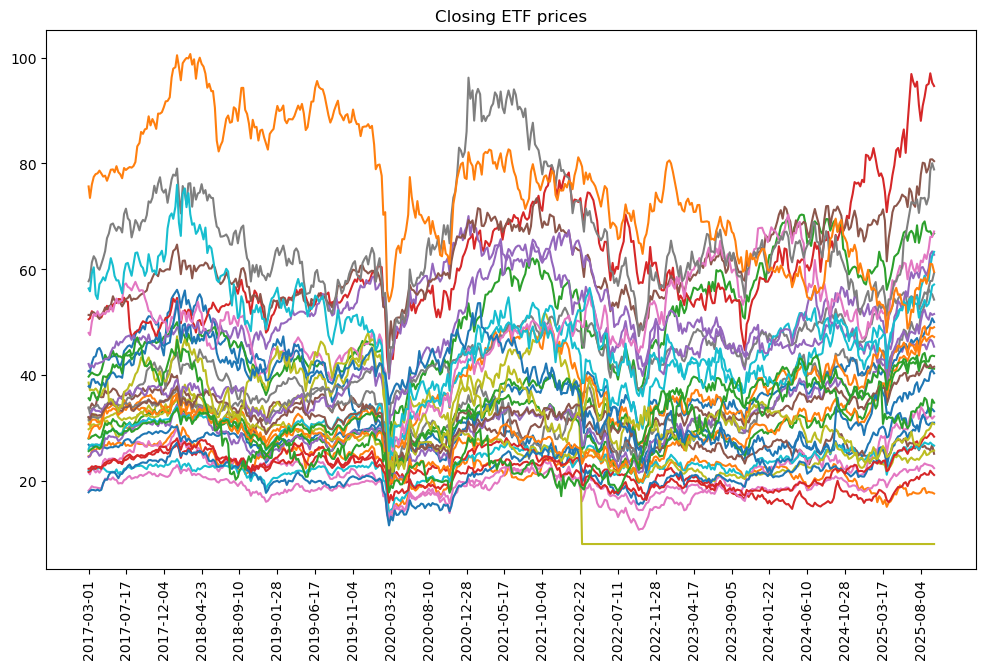

In [62]:
plt.figure(figsize=(12, 7))
plt.plot(df)
plt.xlabel('')
_ = plt.xticks(dates[np.arange(0, len(dates), 20)], rotation=90)
_ = plt.title('Closing ETF prices')
plt.show()

In [63]:
dflogreturn = np.log1p(df.pct_change()).iloc[1:]
dflogreturn

,ECH,EIDO,EIRL,EIS,ENZL,EPHE,EPOL,EPU,ERUS,EWA,...,EWS,EWT,EWU,EWW,EWY,EWZ,EZA,FXI,THD,TUR
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-06,-0.004920,-0.000811,0.009274,0.003753,-0.016042,0.000889,-0.018666,-0.035745,-0.053807,0.003180,...,0.002242,0.000312,-0.011619,-0.008586,0.010854,-0.038578,-0.009447,-0.005826,-0.029100,-0.011296
2017-03-13,0.042488,0.039002,0.009931,0.026269,0.010564,0.025444,0.058100,0.028043,0.065279,0.019758,...,0.018194,0.038896,0.031097,0.051640,0.048986,0.002959,0.059275,0.038812,0.033847,0.039537
2017-03-20,0.024975,0.012798,-0.006692,-0.007325,-0.010323,-0.012787,-0.018390,0.006225,0.006453,-0.014331,...,-0.005291,0.011350,-0.005834,0.029324,0.019070,-0.002959,0.018726,0.002806,0.018894,0.002726
2017-03-27,0.004141,-0.006185,-0.003737,-0.008549,0.018648,-0.000878,-0.023358,0.007067,-0.016366,0.019652,...,0.008365,-0.013154,0.002461,-0.007593,-0.009651,0.009118,-0.089711,-0.019553,0.006690,-0.025646
2017-04-03,0.029184,0.017298,-0.002499,0.004284,-0.001659,0.048567,0.017456,0.009055,-0.006873,-0.013357,...,-0.007039,0.000301,-0.007710,0.017436,-0.024874,-0.012356,-0.014969,0.006474,0.001793,-0.015482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-25,0.000305,-0.053978,-0.025077,0.023269,-0.020301,-0.018189,-0.031058,0.010651,0.000000,-0.006625,...,-0.006032,-0.014180,-0.014844,-0.013789,-0.017428,0.030634,-0.019405,-0.008445,-0.019203,-0.011271
2025-09-02,0.030615,0.014607,-0.003868,0.002845,0.027917,-0.003448,0.013785,0.048967,0.000000,-0.005555,...,0.015187,0.023357,0.002168,0.030057,0.019059,0.004397,0.004326,-0.000257,0.035013,-0.057142
2025-09-08,-0.018196,-0.005593,0.001638,0.020823,0.013137,-0.010027,0.004346,0.022229,0.000000,0.011446,...,0.016684,0.042594,0.009342,0.035248,0.066082,0.013410,0.044737,0.040061,0.029416,-0.032320


In [57]:
np.array(dates)[np.arange(0, len(dates), 20)]
np.arange(0, len(dates), 20)

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
       260, 280, 300, 320, 340, 360, 380, 400, 420, 440])

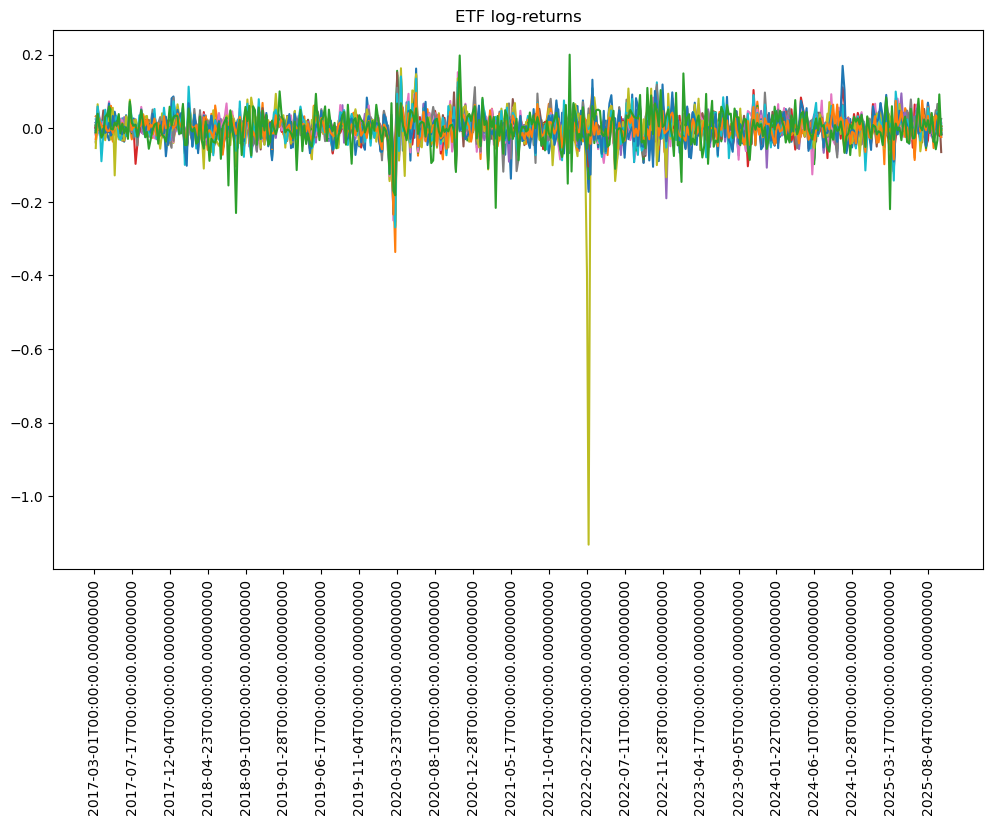

In [64]:
plt.figure(figsize=(12, 7))
plt.plot(dflogreturn)
plt.xlabel('')
plt.xticks(ticks = dates[np.arange(0, len(dates), 20)], labels=np.array(dates)[np.arange(0, len(dates), 20)], rotation=90)
_ = plt.title('ETF log-returns')


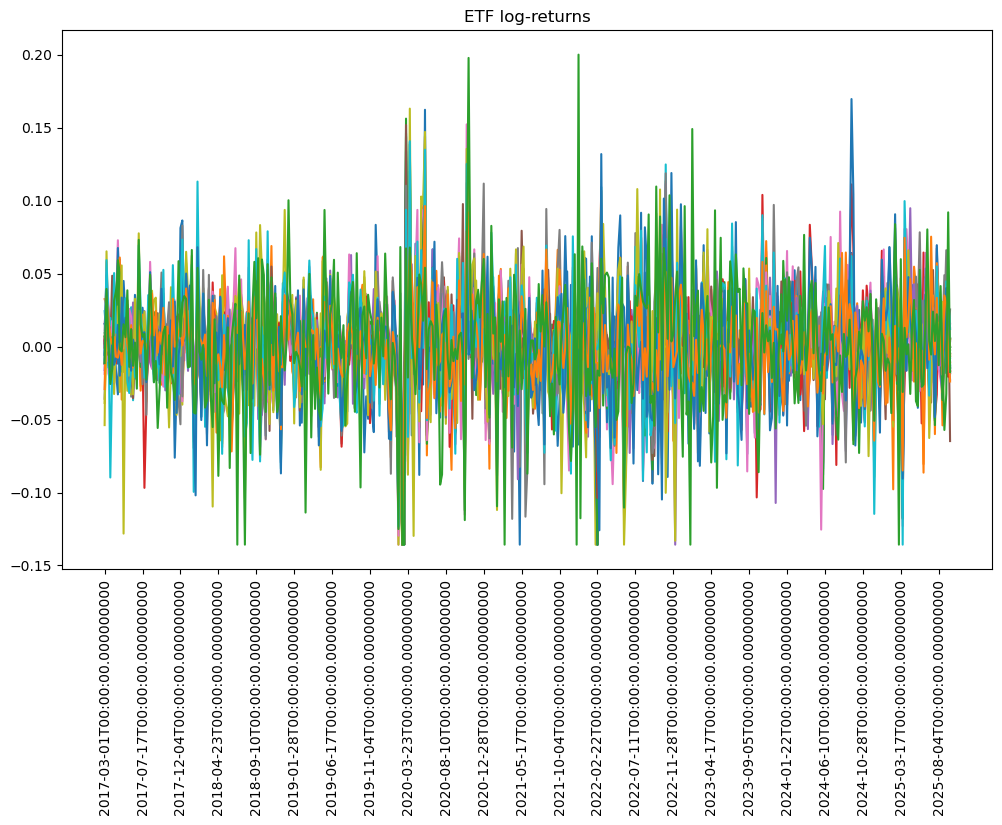

In [65]:
logreturns = np.array(np.log1p(df.pct_change()).iloc[1:])
clipped_logreturns = np.maximum(logreturns, -4*np.std(logreturns))
plt.figure(figsize=(12, 7))
plt.plot(clipped_logreturns)
plt.xlabel('')
plt.xticks(ticks=np.arange(0, len(dates), 20), labels=np.array(dates)[np.arange(0, len(dates), 20)], rotation=90)
_ = plt.title('ETF log-returns')


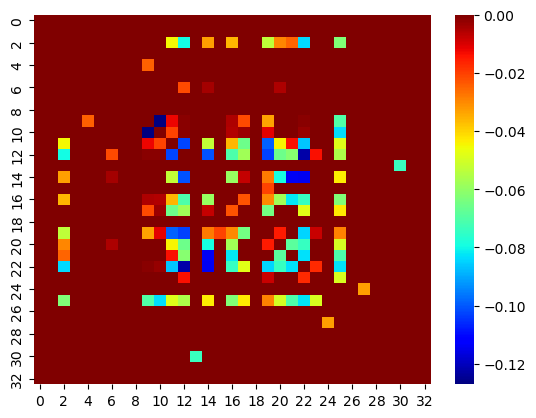

In [66]:
X = np.array(clipped_logreturns)
p = X.shape[1]
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
glasso = GraphicalLasso(alpha=.75).fit(X)
Omegahat = np.around(glasso.precision_, decimals=5)

for j in np.arange(p):
    Omegahat[j,j] = 0
sns.heatmap(Omegahat, cmap='jet')
plt.show()


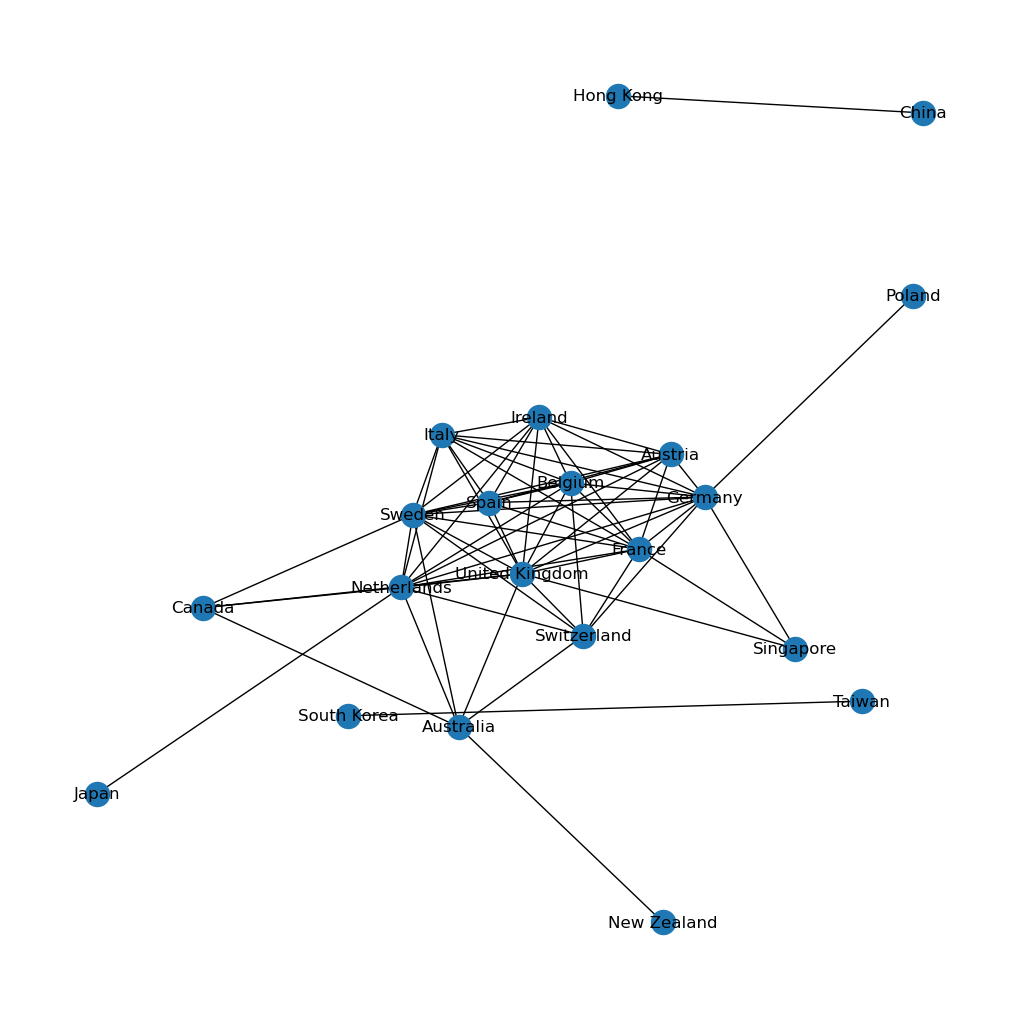

In [69]:
np.random.seed(42)

countries = [etfs[c] for c in dflogreturn.columns]
precdf = pd.DataFrame(Omegahat, columns=countries, index=countries)
links = precdf.stack().reset_index()
links.columns = ['var1', 'var2','value']
links=links.loc[(abs(links['value']) > 0.01) &  (links['var1'] != links['var2']) ]

#build the graph using networkx lib
G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
pos = nx.spring_layout(G, k=1.7/np.sqrt(len(G.nodes())), iterations=20)
plt.figure(3, figsize=(10, 10))
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
plt.show()